## 랜덤포레스트 사용하기
     Load Dataset

In [2]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager,rc

#노트북 안아ㅔ 그래프를 그리기 위해 
%matplotlib inline

#그리프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

#그래프 글꼴 설정
path = 'C:/Windows/Fonts/malgun.ttf'
font_name=font_manager.FontProperties(fname=path).get_name()
rc('font',family=font_name)

In [4]:
train = pd.read_csv('C://BigData/Kaggle/Bike_Sharing_Demand/train.csv',parse_dates=['datetime'])
train.shape

(10886, 12)

In [5]:
test = pd.read_csv('C:/BigData/Kaggle/Bike_Sharing_Demand/test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

### Feature Engineering

In [6]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [7]:
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

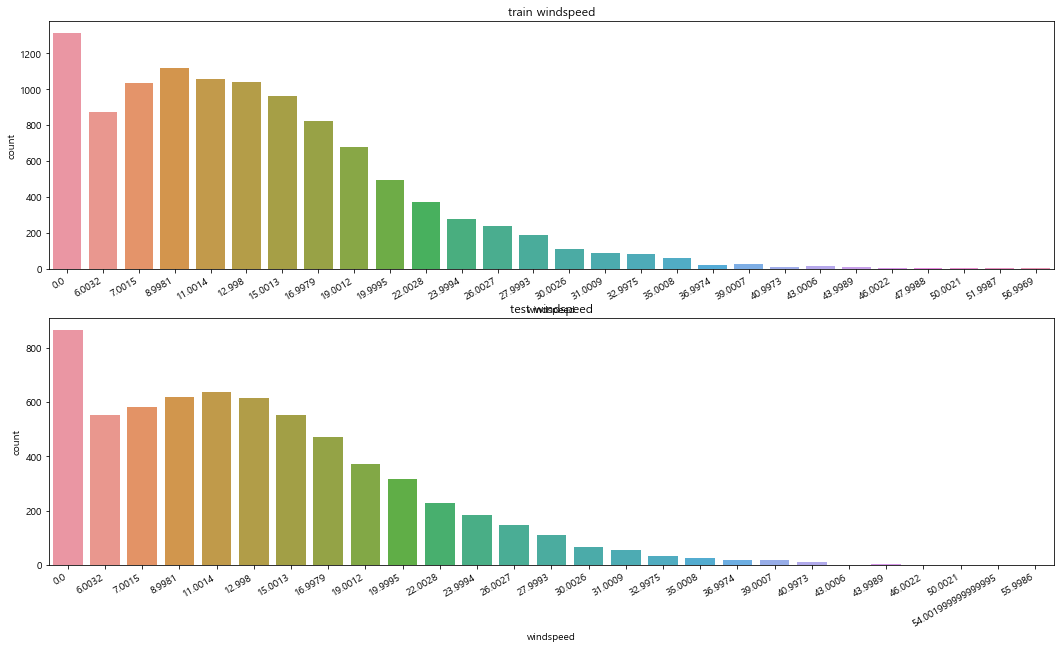

In [9]:
# widspeed  풍속에 0 값이 가장 많다 -> 잘못 기록된 데이터를 고쳐 줄 필요가 있음.
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,10)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel='Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel='Count', title='test windspeed')
sns.countplot(data=test, x='windspeed', ax=axes[1])

 - 풍속의 0 값에 특정 값을 넣어준다.
 - 평균을 구해 일괄적으로 넣어줄 수도 있지만, 예측의 정확도를 높이는 데 도움이 될 것 같진 않다.
 - train.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()
 - test.loc[train["windspeed"] == 0, "windspeed"] = train["windspeed"].mean()

In [11]:
# 풍속이 0인 것과 아닌 것의 세트를 나누어 준다.
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [ ]:
#그래서 머신러닝으로 예측을 해서 풍속을 넣어주도록 한다.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    
    #풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    #풍속을 예측할 피처를 선택한다.
    wCol = ['season', 'weather', 'humidity', 'month', 'temp','year','atemp']
    
    #풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0['windspeed'] == dataWindNot0['windspeed'].astype("str")
    
    #랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()
    
    #wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])
    
    #학습한 값을 바탕으로 풍속이 0으로 기록된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X= dataWind0[wCol])
    
    #값을 다 예측 후 비교해 보기 위해
    #예측한 값을 넣어 줄 데이터 프레임을 새로 만든다. 